✅ Unique diff_mask values: {np.int8(-1): np.int64(5), np.int8(0): np.int64(1038592), np.int8(1): np.int64(9979)}


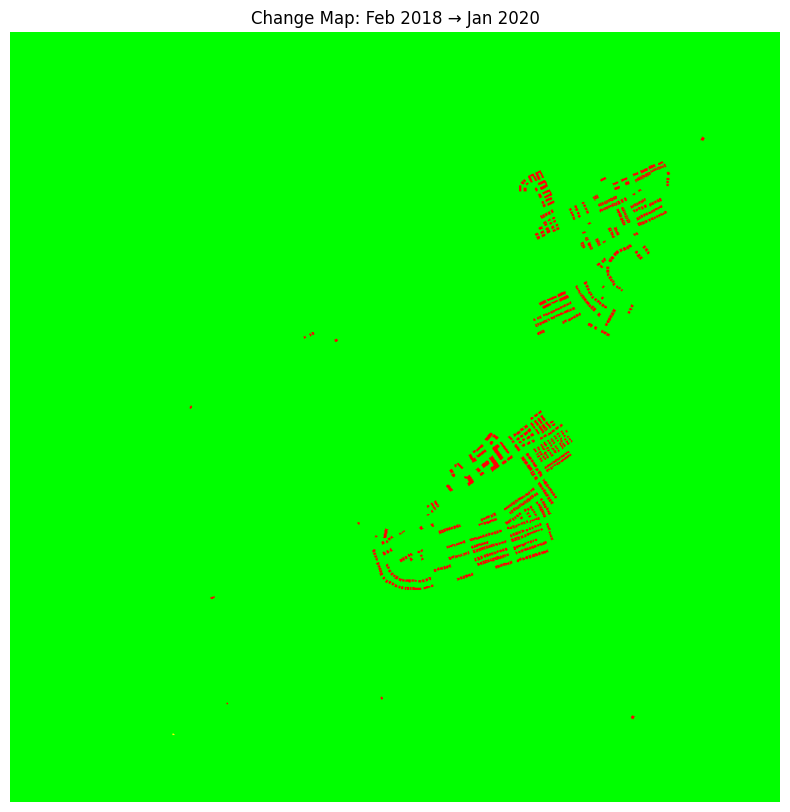

In [ ]:
import os
import re
import numpy as np
import rasterio
from sklearn.cluster import KMeans
from scipy.ndimage import label as nd_label
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
folder_path = "/content/drive/MyDrive/L15-0358E-1220N_1433_3310_13/outputmasks"
tile_id = "L15-0358E-1220N_1433_3310_13"
output_file = f"heatmap_change_kmeans_{tile_id}.jpg"

# === HELPERS ===

def extract_date_from_filename(path):
    match = re.search(r"global_monthly_(\d{4}_\d{2})", path)
    return datetime.strptime(match.group(1), "%Y_%m") if match else None

def extract_lat_lon_from_filename(name):
    pattern = r"L15-(\d{4})([EW])-(\d{4})([NS])"
    match = re.search(pattern, name)
    if match:
        lon_val, lon_dir, lat_val, lat_dir = match.groups()
        lon = float(lon_val) / 10.0 * (-1 if lon_dir == 'W' else 1)
        lat = float(lat_val) / 10.0 * (-1 if lat_dir == 'S' else 1)
        return lat, lon
    return None, None

def load_mask(path):
    with rasterio.open(path) as src:
        if not src.crs or not src.crs.is_projected:
            raise ValueError(f"❌ Skipping: {os.path.basename(path)} is not in projected CRS (meters).")
        mask = src.read(1).astype(np.uint8)
        transform = src.transform
        pixel_size = transform[0]
    return mask, pixel_size

# === STEP 1: Get Chronological Mask Files ===

tif_files = sorted(
    [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")],
    key=lambda x: extract_date_from_filename(x)
)

if len(tif_files) < 2:
    raise ValueError("❌ Not enough .tif files to perform change detection.")

mask1_path, mask2_path = tif_files[0], tif_files[-1]  # Earliest and latest

# === STEP 2: Load Masks and Validate CRS ===

mask1, px_size = load_mask(mask1_path)
mask2, _ = load_mask(mask2_path)
pixel_area_m2 = px_size * px_size
pixel_area_acres = pixel_area_m2 * 0.000247105

# === STEP 3: Difference and KMeans ===

diff_mask = (mask2 > 0).astype(np.int8) - (mask1 > 0).astype(np.int8)
flat = diff_mask.reshape(-1, 1)

# Sanity check
unique_vals, unique_counts = np.unique(diff_mask, return_counts=True)
print("✅ Unique diff_mask values:", dict(zip(unique_vals, unique_counts)))

new_pixels = np.sum(diff_mask == 1)
removed_pixels = np.sum(diff_mask == -1)
change_pixels = new_pixels + removed_pixels

# No-change condition
if new_pixels == 0 and removed_pixels == 0:
    print("✅ No change detected between the two masks.")
    semantic_map = np.full_like(diff_mask, 'no', dtype=object)
    new_building_count = 0
else:
    # KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans.fit(flat)
    clustered = kmeans.labels_.reshape(diff_mask.shape)

    # Majority voting
    label_mapping = {}
    for label in range(3):
        cluster_values = flat[kmeans.labels_ == label].flatten()
        majority = np.bincount(cluster_values + 1).argmax() - 1
        label_mapping[label] = majority

    semantic_map = np.full_like(clustered, 'unknown', dtype=object)
    for label, diff_val in label_mapping.items():
        if diff_val == 0:
            semantic_map[clustered == label] = 'no'
        elif diff_val == 1:
            semantic_map[clustered == label] = 'high'
        elif diff_val == -1:
            semantic_map[clustered == label] = 'moderate'

    _, new_building_count = nd_label(diff_mask == 1)

# === STEP 4: Area and Building Count Calculations ===

# Building area
prev_building_pixels = np.sum(mask1 > 0)
curr_building_pixels = np.sum(mask2 > 0)

prev_area_m2 = prev_building_pixels * pixel_area_m2
curr_area_m2 = curr_building_pixels * pixel_area_m2

# Convert to acres
prev_area_acres = prev_area_m2 * 0.000247105
curr_area_acres = curr_area_m2 * 0.000247105
area_change_acres = curr_area_acres - prev_area_acres

# Building count
_, prev_building_count = nd_label(mask1 > 0)
_, curr_building_count = nd_label(mask2 > 0)

# === STEP 5: Metadata ===

lat, lon = extract_lat_lon_from_filename(mask1_path)
start_date = extract_date_from_filename(mask1_path)
end_date = extract_date_from_filename(mask2_path)

# === STEP 6: Final Output (Clean Comparison) ===

result = {
    "latitude": lat,
    "longitude": lon,
    "start_date": start_date.strftime("%Y-%m"),
    "end_date": end_date.strftime("%Y-%m"),
    "prev_area_acres": prev_area_acres,
    "curr_area_acres": curr_area_acres,
    "area_change_acres": area_change_acres,
    "prev_building_count": prev_building_count,
    "curr_building_count": curr_building_count,
    "new_building_count": new_building_count
}

df = pd.DataFrame([result])


# === STEP 7: Heatmap ===

color_map = {
    'no': [0, 255, 0],
    'moderate': [255, 255, 0],
    'high': [255, 0, 0]
}

heatmap = np.zeros((*semantic_map.shape, 3), dtype=np.uint8)
for label in color_map:
    heatmap[semantic_map == label] = color_map[label]

plt.figure(figsize=(10, 10))
plt.imshow(heatmap)
plt.title(f"Change Map: {start_date.strftime('%b %Y')} → {end_date.strftime('%b %Y')}")
plt.axis('off')
plt.savefig(output_file, bbox_inches='tight')
plt.show()

In [ ]:
df

,latitude,longitude,start_date,end_date,prev_area_acres,curr_area_acres,area_change_acres,prev_building_count,curr_building_count,new_building_count
0,122.0,35.8,2018-02,2020-01,281.478629,337.72811,56.249481,3237,3714,506


✅ Saved monthly pairwise analysis to L15-0358E-1220N_1433_3310_13_monthly_pairwise_comparison.csv


<ipython-input-8-974f24bd4854>:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


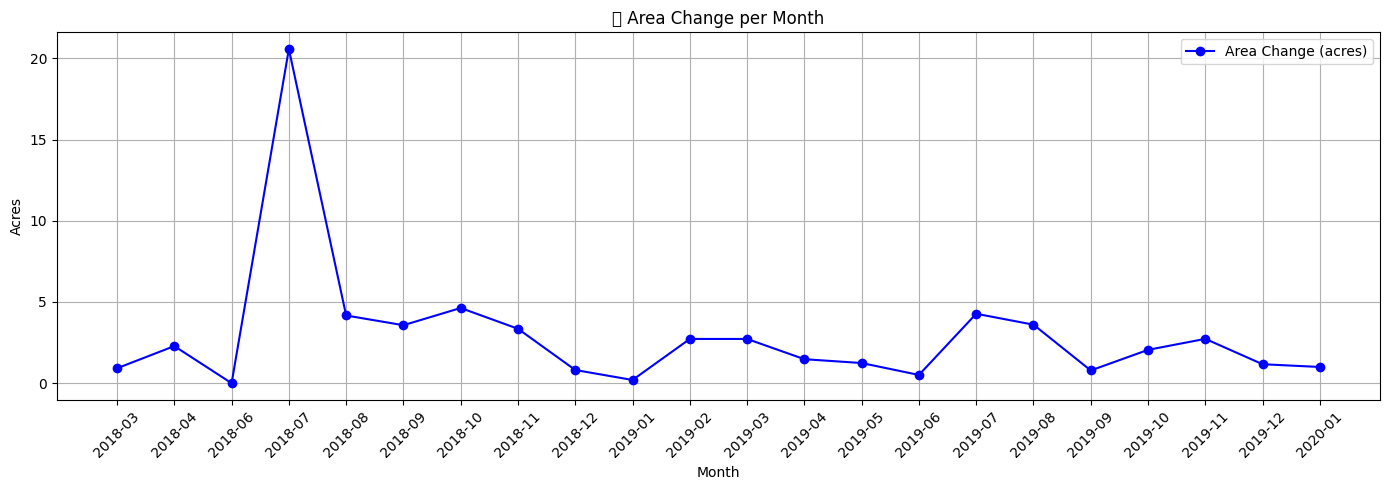

<ipython-input-8-974f24bd4854>:119: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


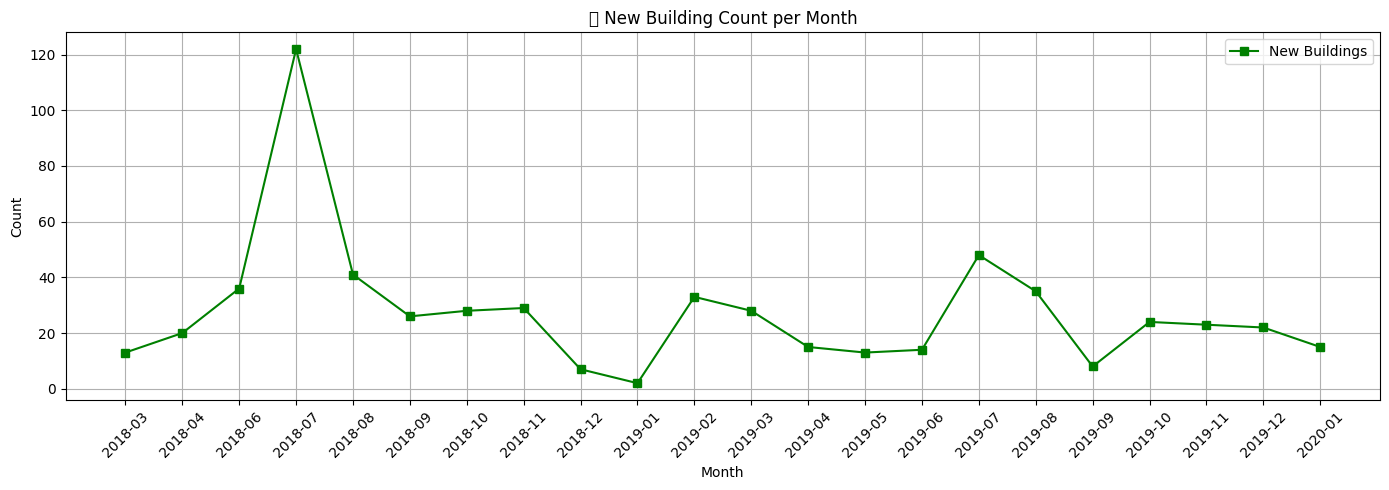

In [8]:
import os
import re
import numpy as np
import rasterio
from sklearn.cluster import KMeans
from scipy.ndimage import label as nd_label
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
folder_path = "/content/drive/MyDrive/L15-0358E-1220N_1433_3310_13/outputmasks"
tile_id = "L15-0358E-1220N_1433_3310_13"
results = []

def extract_date_from_filename(path):
    match = re.search(r"global_monthly_(\d{4}_\d{2})", path)
    return datetime.strptime(match.group(1), "%Y_%m") if match else None

def extract_lat_lon_from_filename(name):
    pattern = r"L15-(\d{4})([EW])-(\d{4})([NS])"
    match = re.search(pattern, name)
    if match:
        lon_val, lon_dir, lat_val, lat_dir = match.groups()
        lon = float(lon_val) / 10.0 * (-1 if lon_dir == 'W' else 1)
        lat = float(lat_val) / 10.0 * (-1 if lat_dir == 'S' else 1)
        return lat, lon
    return None, None

def load_mask(path):
    with rasterio.open(path) as src:
        if not src.crs or not src.crs.is_projected:
            raise ValueError(f"❌ Skipping: {os.path.basename(path)} is not in projected CRS (meters).")
        mask = src.read(1).astype(np.uint8)
        transform = src.transform
        pixel_size = transform[0]
    return mask, pixel_size

# === STEP 1: Load and Sort All TIF Files ===
tif_files = sorted(
    [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")],
    key=lambda x: extract_date_from_filename(x)
)

# === STEP 2: Month-to-Month Comparison ===
for i in range(len(tif_files) - 1):
    mask1_path, mask2_path = tif_files[i], tif_files[i + 1]
    try:
        mask1, px_size = load_mask(mask1_path)
        mask2, _ = load_mask(mask2_path)
    except Exception as e:
        print(f"⚠️ Skipping pair {mask1_path} -> {mask2_path}: {e}")
        continue

    pixel_area_m2 = px_size * px_size
    pixel_area_acres = pixel_area_m2 * 0.000247105

    diff_mask = (mask2 > 0).astype(np.int8) - (mask1 > 0).astype(np.int8)

    new_pixels = np.sum(diff_mask == 1)
    removed_pixels = np.sum(diff_mask == -1)

    _, new_building_count = nd_label(diff_mask == 1)
    _, prev_building_count = nd_label(mask1 > 0)
    _, curr_building_count = nd_label(mask2 > 0)

    prev_area_acres = np.sum(mask1 > 0) * pixel_area_acres
    curr_area_acres = np.sum(mask2 > 0) * pixel_area_acres
    area_change_acres = curr_area_acres - prev_area_acres

    start_date = extract_date_from_filename(mask1_path)
    end_date = extract_date_from_filename(mask2_path)
    lat, lon = extract_lat_lon_from_filename(mask1_path)

    results.append({
        "start_date": start_date,
        "end_date": end_date,
        "latitude": lat,
        "longitude": lon,
        "prev_area_acres": round(prev_area_acres, 4),
        "curr_area_acres": round(curr_area_acres, 4),
        "area_change_acres": round(area_change_acres, 4),
        "prev_building_count": prev_building_count,
        "curr_building_count": curr_building_count,
        "new_building_count": new_building_count,
        "change_type": "Growth" if area_change_acres >= 0 else "Decline"
    })

# === STEP 3: Create DataFrame and Save ===
df = pd.DataFrame(results)
df["month"] = df["end_date"].dt.strftime("%Y-%m")
df["area_change_acres"] = df["area_change_acres"].clip(lower=0)

# Save to CSV
output_csv = f"{tile_id}_monthly_pairwise_comparison.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Saved monthly pairwise analysis to {output_csv}")

# === STEP 4: Plots ===
plt.figure(figsize=(14, 5))
plt.plot(df["month"], df["area_change_acres"], marker='o', color='blue', label="Area Change (acres)")
plt.xticks(rotation=45)
plt.title("📈 Area Change per Month")
plt.xlabel("Month")
plt.ylabel("Acres")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df["month"], df["new_building_count"], marker='s', color='green', label="New Buildings")
plt.xticks(rotation=45)
plt.title("🏗️ New Building Count per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: View table previe


In [9]:
df

,start_date,end_date,latitude,longitude,prev_area_acres,curr_area_acres,area_change_acres,prev_building_count,curr_building_count,new_building_count,change_type,month
0,2018-02-01,2018-03-01,122.0,35.8,281.4786,282.3979,0.9193,3237,3243,13,Growth,2018-03
1,2018-03-01,2018-04-01,122.0,35.8,282.3979,284.6819,2.2840,3243,3254,20,Growth,2018-04
2,2018-04-01,2018-06-01,122.0,35.8,284.6819,276.1436,0.0000,3254,3249,36,Decline,2018-06
3,2018-06-01,2018-07-01,122.0,35.8,276.1436,296.7169,20.5733,3249,3361,122,Growth,2018-07
4,2018-07-01,2018-08-01,122.0,35.8,296.7169,300.8845,4.1677,3361,3396,41,Growth,2018-08
5,2018-08-01,2018-09-01,122.0,35.8,300.8845,304.4544,3.5699,3396,3421,26,Growth,2018-09
6,2018-09-01,2018-10-01,122.0,35.8,304.4544,309.0845,4.6301,3421,3446,28,Growth,2018-10
7,2018-10-01,2018-11-01,122.0,35.8,309.0845,312.4345,3.3499,3446,3472,29,Growth,2018-11
8,2018-11-01,2018-12-01,122.0,35.8,312.4345,313.2466,0.8121,3472,3477,7,Growth,2018-12
9,2018-12-01,2019-01-01,122.0,35.8,313.2466,313.4439,0.1974,3477,3478,2,Growth,2019-01


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from skimage.measure import label, regionprops

# === CONFIG ===
MASK_FOLDER = r"/content/drive/MyDrive/L15-0358E-1220N_1433_3310_13/outputmasks"
LOCATION_ID = "L15-0358E-1220N"
ACRE_CONVERSION = 0.000247105
TILE_SIZE = 512
TILE_DEGREE_SPAN = 0.05
IOU_THRESHOLD = 0.3
DIST_THRESHOLD = 0.0005
MIN_AREA = 20

# === EXTRACT DATE FROM FILENAME ===
def extract_date_from_filename(filename):
    match = re.search(r'_(20\d{2})_(0[1-9]|1[0-2])_', filename)
    if match:
        year, month = match.groups()
        return f"{year}-{month}-01"
    return None

# === PARSE LAT LON FROM FOLDER NAME ===
def parse_latlon_from_tile(tile_name):
    lon_str = re.search(r'-(\d+)E', tile_name).group(1)
    lat_str = re.search(r'-(\d+)N', tile_name).group(1)
    lon = int(lon_str) / 10
    lat = int(lat_str) / 10
    return lon, lat

# === PIXEL TO LAT/LON CONVERSION ===
def pixel_to_latlon(row, col, tile_lat, tile_lon):
    lat_per_pixel = TILE_DEGREE_SPAN / TILE_SIZE
    lon_per_pixel = TILE_DEGREE_SPAN / TILE_SIZE
    lat = tile_lat - row * lat_per_pixel
    lon = tile_lon + col * lon_per_pixel
    return round(lat, 6), round(lon, 6)

# === IOU CALCULATION ===
def compute_iou(mask1, mask2):
    try:
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        return intersection / union if union != 0 else 0
    except MemoryError:
        return 0

# === LOAD MASKS ===
def load_masks(mask_folder):
    files = sorted([f for f in os.listdir(mask_folder) if f.endswith(('.png', '.tif'))])
    masks, months = [], []
    for file in files:
        img = plt.imread(os.path.join(mask_folder, file))
        masks.append((img > 0.5).astype(np.uint8))
        date_str = extract_date_from_filename(file)
        months.append(date_str if date_str else "0000-00-00")
    return masks, months

# === SEASON ASSIGNMENT ===
def assign_season(date_str):
    try:
        _, month, _ = date_str.split("-")
        month = int(month)
        if 3 <= month <= 6:
            return "Summer"
        elif 7 <= month <= 9:
            return "Monsoon"
        else:
            return "Winter"
    except:
        return "Unknown"

# === TRACK BUILDINGS WITH IOU + SPATIAL FILTER ===
def track_buildings_with_iou(masks, months, tile_lat, tile_lon):
    building_id = 0
    active_buildings = {}
    all_buildings = []

    for t, mask in enumerate(masks):
        labeled = label(mask)
        regions = regionprops(labeled)
        matched_ids = set()

        for region in regions:
            if region.area < MIN_AREA:
                continue

            r_mask = np.zeros_like(mask)
            coords = region.coords
            for x, y in coords:
                r_mask[x, y] = 1

            row, col = region.centroid
            lat, lon = pixel_to_latlon(row, col, tile_lat, tile_lon)

            matched_id = None
            for b_id, b in active_buildings.items():
                dist = np.sqrt((b['lat'] - lat) ** 2 + (b['lon'] - lon) ** 2)
                if dist > DIST_THRESHOLD:
                    continue

                iou = compute_iou(r_mask, b['mask'])
                if iou > IOU_THRESHOLD:
                    matched_id = b_id
                    break

            if matched_id:
                active_buildings[matched_id]['end'] = t
                active_buildings[matched_id]['mask'] = r_mask
                matched_ids.add(matched_id)
            else:
                building_id += 1
                active_buildings[building_id] = {
                    'start': t,
                    'end': t,
                    'lat': lat,
                    'lon': lon,
                    'mask': r_mask
                }

        to_remove = [b_id for b_id in active_buildings if b_id not in matched_ids and active_buildings[b_id]['end'] < t - 1]
        for b_id in to_remove:
            b = active_buildings[b_id]
            all_buildings.append({
                'BuildingID': b_id,
                'StartMonth': months[b['start']],
                'EndMonth': months[b['end']],
                'Duration': b['end'] - b['start'] + 1,
                'Acres': b['mask'].sum() * ACRE_CONVERSION,
                'Latitude': b['lat'],
                'Longitude': b['lon'],
                'Location': LOCATION_ID
            })
            del active_buildings[b_id]

    for b_id, b in active_buildings.items():
        all_buildings.append({
            'BuildingID': b_id,
            'StartMonth': months[b['start']],
            'EndMonth': months[b['end']],
            'Duration': b['end'] - b['start'] + 1,
            'Acres': b['mask'].sum() * ACRE_CONVERSION,
            'Latitude': b['lat'],
            'Longitude': b['lon'],
            'Location': LOCATION_ID
        })

    df = pd.DataFrame(all_buildings)
    first_month = df['StartMonth'].min()
    return df[df['StartMonth'] != first_month]

# === RUN ===
tile_lon, tile_lat = parse_latlon_from_tile(LOCATION_ID)
masks, months = load_masks(MASK_FOLDER)
building_df = track_buildings_with_iou(masks, months, tile_lat, tile_lon)
building_df = building_df[~building_df['StartMonth'].str.contains("0000")]
building_df['SeasonStarted'] = building_df['StartMonth'].apply(assign_season)
building_df['SeasonCompleted'] = building_df['EndMonth'].apply(assign_season)

# === CONVERT TO GEODATAFRAME ===
gdf = gpd.GeoDataFrame(
    building_df,
    geometry=[Point(xy) for xy in zip(building_df['Longitude'], building_df['Latitude'])],
    crs="EPSG:4326"
)

# === SAVE ===
gdf.to_file("new_constructions_only.geojson", driver="GeoJSON")
gdf.to_csv("new_constructions_only.csv", index=False)
print("✅ Saved to new_constructions_only.geojson and new_constructions_only.csv")
print("\n📅 Season Start-End Summary (New Only):")
print(building_df[['SeasonStarted', 'SeasonCompleted']].value_counts())
print("\n📍 Sample New Constructions:")
print(building_df.head())

✅ Saved to new_constructions_only.geojson and new_constructions_only.csv

📅 Season Start-End Summary (New Only):
SeasonStarted  SeasonCompleted
Monsoon        Winter             70
Winter         Winter             62
Summer         Winter             36
               Summer             11
               Monsoon             3
Monsoon        Summer              3
               Monsoon             3
Winter         Summer              2
Name: count, dtype: int64

📍 Sample New Constructions:
    BuildingID  StartMonth    EndMonth  Duration     Acres    Latitude  \
7          668  2018-03-01  2018-04-01         2  0.013097  121.938008   
8          675  2018-04-01  2018-04-01         1  0.011120  121.936547   
9          676  2018-04-01  2018-04-01         1  0.004942  121.936055   
10         677  2018-04-01  2018-04-01         1  0.008896  121.929487   
12         674  2018-04-01  2018-06-01         2  0.020757  121.937550   

    Longitude         Location SeasonStarted SeasonCompleted

In [2]:
building_df

,BuildingID,StartMonth,EndMonth,Duration,Acres,Latitude,Longitude,Location,SeasonStarted,SeasonCompleted
7,668,2018-03-01,2018-04-01,2,0.013097,121.938008,35.864126,L15-0358E-1220N,Summer,Summer
8,675,2018-04-01,2018-04-01,1,0.011120,121.936547,35.862483,L15-0358E-1220N,Summer,Summer
9,676,2018-04-01,2018-04-01,1,0.004942,121.936055,35.860923,L15-0358E-1220N,Summer,Summer
10,677,2018-04-01,2018-04-01,1,0.008896,121.929487,35.859565,L15-0358E-1220N,Summer,Summer
12,674,2018-04-01,2018-06-01,2,0.020757,121.937550,35.864769,L15-0358E-1220N,Summer,Summer
...,...,...,...,...,...,...,...,...,...,...
848,849,2019-12-01,2020-01-01,2,0.008896,121.939355,35.870020,L15-0358E-1220N,Winter,Winter
849,850,2019-12-01,2020-01-01,2,0.005931,121.932878,35.849581,L15-0358E-1220N,Winter,Winter
850,851,2019-12-01,2020-01-01,2,0.004942,121.932134,35.851909,L15-0358E-1220N,Winter,Winter
851,852,2020-01-01,2020-01-01,1,0.006425,121.986268,35.889814,L15-0358E-1220N,Winter,Winter


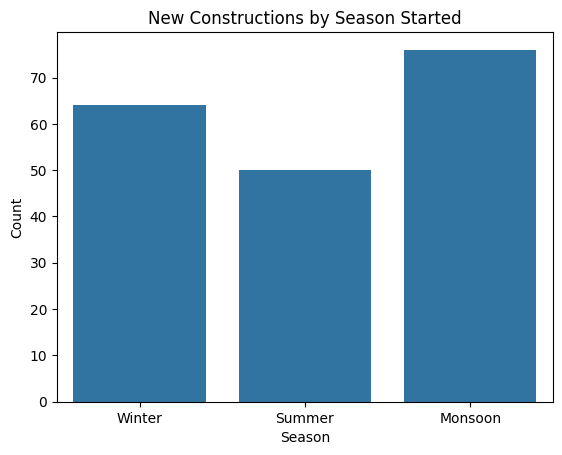

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=building_df, x='SeasonStarted', order=['Winter', 'Summer', 'Monsoon'])
plt.title("New Constructions by Season Started")
plt.ylabel("Count")
plt.xlabel("Season")
plt.show()


📋 Monthly Summary Table:

╒════╤═════════════════════╤════════════════════════╤════════════════╤═════════════════╕
│    │ Month               │   Area (square meters) │   Area (acres) │   New Buildings │
╞════╪═════════════════════╪════════════════════════╪════════════════╪═════════════════╡
│  0 │ 2018-03-01 00:00:00 │                    235 │         0.0581 │               5 │
├────┼─────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│  1 │ 2018-04-01 00:00:00 │                    322 │         0.0796 │               9 │
├────┼─────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│  2 │ 2018-06-01 00:00:00 │                   1073 │         0.2651 │              16 │
├────┼─────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│  3 │ 2018-07-01 00:00:00 │                   1246 │         0.3079 │              19 │
├────┼─────────────────────┼────────────────────────┼────────────────┼─────────────

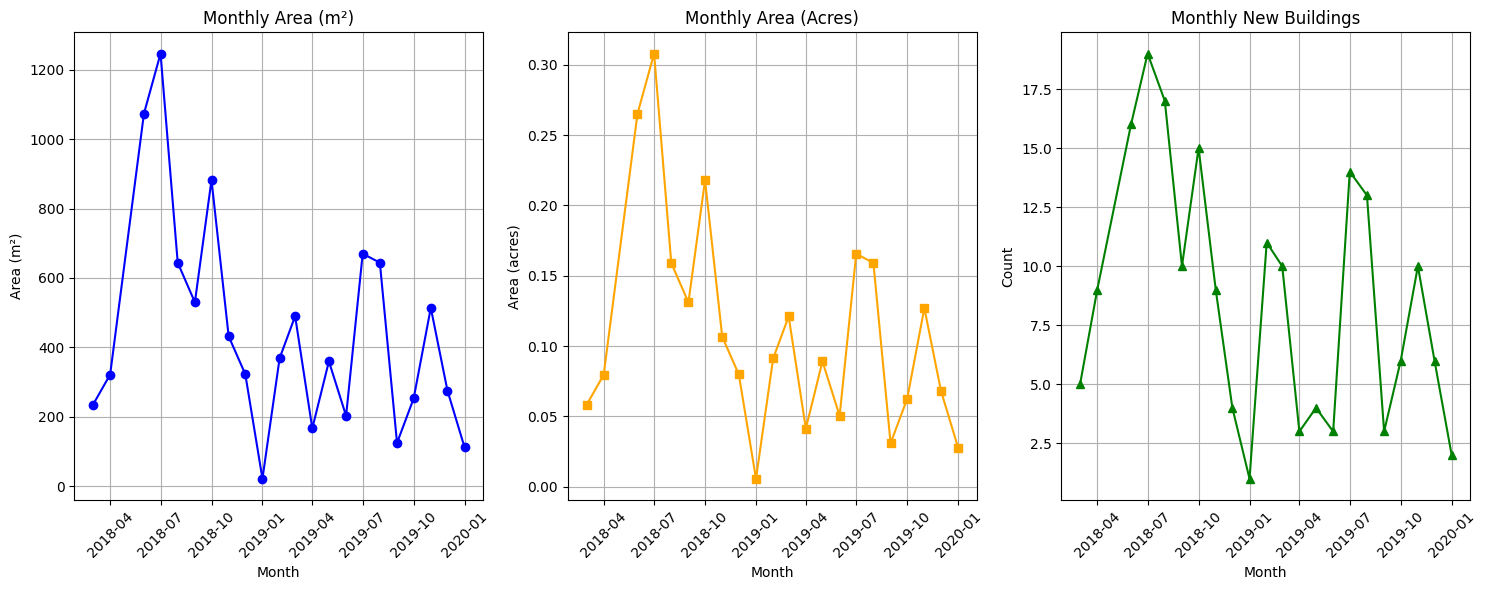

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# === Load Data ===
csv_path = r"/content/new_constructions_only.csv"
df = pd.read_csv(csv_path)

# === Constants ===
ACRE_CONVERSION = 0.000247105

# === Add Area in m² ===
df['Area_m2'] = df['Acres'] / ACRE_CONVERSION

# === Convert StartMonth to datetime for sorting ===
df['StartMonth'] = pd.to_datetime(df['StartMonth'], format="%Y-%m-%d")

# === Monthly Grouping ===
monthly_summary = df.groupby(df['StartMonth'].dt.to_period("M")).agg({
    'Area_m2': 'sum',
    'Acres': 'sum',
    'Latitude': 'count'  # Latitude count == new building count
}).rename(columns={'Latitude': 'New Buildings'}).reset_index()

monthly_summary['StartMonth'] = monthly_summary['StartMonth'].dt.to_timestamp()
monthly_summary.columns = ['Month', 'Area (square meters)', 'Area (acres)', 'New Buildings']

# Format data
monthly_summary['Area (square meters)'] = monthly_summary['Area (square meters)'].astype(int)
monthly_summary['Area (acres)'] = monthly_summary['Area (acres)'].round(4)

# === Print Table in Box Format ===
print("\n📋 Monthly Summary Table:\n")
print(tabulate(monthly_summary, headers='keys', tablefmt='fancy_grid'))

# === Plotting ===
plt.figure(figsize=(15, 6))

# 1. Area in m²
plt.subplot(1, 3, 1)
plt.plot(monthly_summary['Month'], monthly_summary['Area (square meters)'], marker='o', color='blue')
plt.title('Monthly Area (m²)')
plt.xlabel('Month')
plt.ylabel('Area (m²)')
plt.xticks(rotation=45)
plt.grid(True)

# 2. Area in Acres
plt.subplot(1, 3, 2)
plt.plot(monthly_summary['Month'], monthly_summary['Area (acres)'], marker='s', color='orange')
plt.title('Monthly Area (Acres)')
plt.xlabel('Month')
plt.ylabel('Area (acres)')
plt.xticks(rotation=45)
plt.grid(True)

# 3. New Buildings
plt.subplot(1, 3, 3)
plt.plot(monthly_summary['Month'], monthly_summary['New Buildings'], marker='^', color='green')
plt.title('Monthly New Buildings')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()